In this lab, we will build a convolutional neural network using the PyTorch library for image classification on the Extended MNIST dataset. MNIST is a widely known dataset of handwritten digits (0-9) that was originally used by Yann LeCun in their 1998 paper on document recognition. It quickly became a “toy” dataset because of the ease of obtaining high accuracy with various models. As a result, Gregory Cohen published a more challenging version known as the Extended MNIST (EMNIST) dataset in 2017. This dataset comes from the same NIST source except that it also includes letters in addition to all the digits. So there are 47 classes: digits 0-9, uppercase letters A-Z, and lowercase letters a, b, d, e, f, g, h, n, q, r, t. They omitted any lowercase letters that closely resembled their uppercase counterparts (or likely just grouped them into their respective uppercase class). We chose to use Cohen’s EMNIST Balanced dataset because it had a reasonable size of 131,600 images with balanced classes. This way it wouldn’t require excessive computing power to train, and we wouldn’t have to deal with issues of imbalance. Each image is 28 x 28 pixels in grayscale and is fully pre-processed, meaning they are size-normalized, centered, and fixed-size. This allows for immediate deployment in the machine learning model; no data wrangling necessary. The details of the dataset are shown in
Figure 1 and a sample of the dataset is shown in Figure 2. Cohen’s purpose was to release a more challenging dataset than the original MNIST which had become almost trivial with modern techniques. Figure 3 shows the accuracy of neural nets with various numbers of hidden nodes on the EMNIST and original MNIST datasets (using the exact same network). In the following sections, we demonstrate how much more challenging the EMNIST dataset actually is.

In [2]:
# import libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [3]:
# split train set from test set
train_set = datasets.EMNIST(
    root='data',
    split='balanced',
    train=True,
    download=True,
    transform=ToTensor()
)

test_set = datasets.EMNIST(
    root='data',
    split='balanced',
    train=False,
    download=True,
    transform=ToTensor()
)

full_train_set = DataLoader(
    train_set,
    shuffle=True)

# make validation split
train_split = int(0.8*len(full_train_set))
val_split = len(full_train_set) - train_split

train_set, val_set = torch.utils.data.random_split(full_train_set.dataset, [train_split, val_split])
print(f'Train size: {train_split}, Val size: {val_split}')

batch_size=64

# train loader and val_loader
train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True)

val_loader = DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=True)

Train size: 90240, Val size: 22560


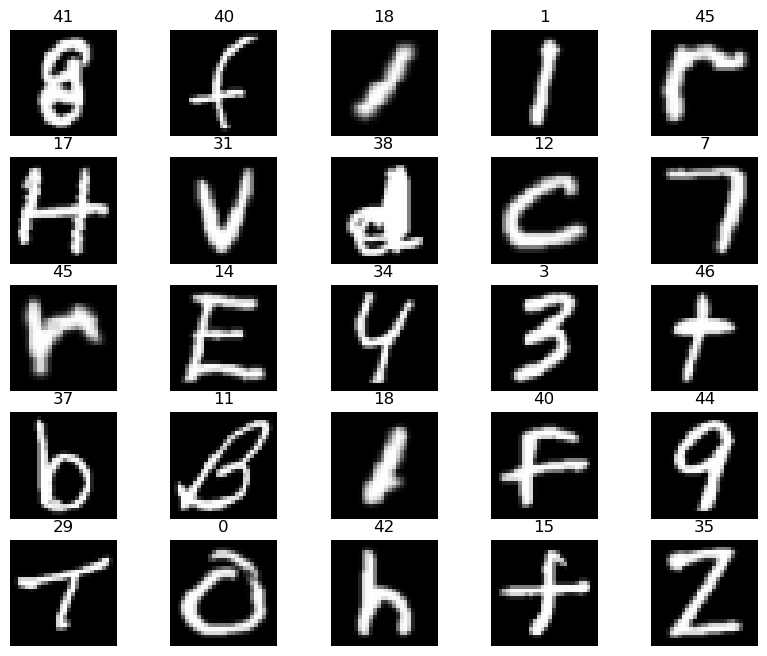

In [5]:
# a small sample of the training set
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.mT.squeeze(), cmap="gray")
plt.show()

In [6]:
# define train loop and test loop
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [141]:
# define all model architectures to train/test
# INT = Conv2d(in_channels=INT, out_channels=2*INT, kernel_size=3, stride=1, padding='same')
# R = ReLU activation function
# B = Batch normalization
# D = Dropout(0.2)
# M = Max pooling(kernel_size=2, stride=1)
model_code = {
    'm1': [8, 'R', 'M'],
    'm2': [8, 'B', 'R', 'M'],
    'm3': [8, 'R', 'M', 16, 'R', 'M'],
    'm4': [8, 'B', 'R', 'M', 16, 'B', 'R', 'M'],
    'm5': [8, 'R', 'M', 'D', 16, 'R', 'M'],
    'm6': [8, 'B', 'R', 'M', 'D', 16, 'B', 'R', 'M'],
    'm7': [8, 'R', 'M', 16, 'R', 'M', 32, 'R', 'M'],
    'm8': [8, 'B', 'R', 'M', 16, 'B', 'R', 'M', 32, 'B', 'R', 'M'],
    'm9': [8, 'R', 'M', 'D', 16, 'R', 'M', 'D', 32, 'R', 'M'],
    'm10':[8, 'B', 'R', 'M', 'D', 16, 'B', 'R', 'M', 'D', 32, 'R', 'M'],
}

#models = ['m1', 'm3', 'm5', 'm7', 'm9', 'm11', 'm13']

In [139]:
# define neural net class with easily tunable architecture
class CNN(nn.Module):
    def __init__(self, m, model_code, fc):
        super(CNN, self).__init__()
        # 3 convolutional layers
        # input shape = 28x28
        size_in = 1
        size_shape = 28
        self.layers, size_in, size_shape = self.make_layers(m, model_code, size_in, size_shape)
        if fc == 1:
            self.classifier = nn.Linear(in_features=size_in*size_shape*size_shape, out_features=47)
        elif fc == 2:
            self.classifier = nn.Sequential(nn.Linear(in_features=size_in*size_shape*size_shape, out_features=256),
                                            nn.ReLU(),
                                            nn.Linear(in_features=256, out_features=47))
        elif fc == 3:
            self.classifier = nn.Sequential(nn.Linear(in_features=size_in*size_shape*size_shape, out_features=256),
                                            nn.ReLU(),
                                            nn.Linear(in_features=256, out_features=128),
                                            nn.ReLU(),
                                            nn.Linear(in_features=128, out_features=47))
                             
    def make_layers(self, m, model_code, size_in, size_shape):
        layers = []
        size_out = 8
        for code in model_code[m]:
            if code == 'R':
                layers += [nn.ReLU()]
            elif code == 'S':
                layers += [nn.Sigmoid()]
            elif code == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=1)]
                size_shape -= 1
            elif code == 'B':
                layers += [nn.BatchNorm2d(size_in)]
            elif code == 'D':
                layers += [nn.Dropout(0.2)]
            else:
                layers += [nn.Conv2d(in_channels=size_in, out_channels=size_out, kernel_size=3, stride=1, padding='same')]
                size_in = size_out
                size_out *= 2
                             
        return (nn.Sequential(*layers), size_in, size_shape)
        
    def forward(self, x):
        x = self.layers(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.classifier(x)
        
        return x

In [140]:
# define which models to train/test
# run train/test loop

# try all model architectures
models = ['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10']

for m in models:
    for fc in [1, 2, 3]:
        net = CNN(m, model_code, fc)
        for lr in [-3]:
            learning_rate = 10 ** lr
            for momentum in [0.8]:
                epochs = 10
                loss_fn = nn.CrossEntropyLoss()
                optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
                #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

                print('model :', m)
                print(net)
                print('learning rate: ', learning_rate)
                print('momentum: ', momentum)
                for t in range(epochs):
                    print(f"Epoch {t+1}\n-------------------------------")
                    train_loop(train_loader, net, loss_fn, optimizer)
                    test_loop(val_loader, net, loss_fn)
                print("Done!")

model : m1
CNN(
  (layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Linear(in_features=5832, out_features=47, bias=True)
)
learning rate:  0.001
momentum:  0.8
Epoch 1
-------------------------------
loss: 3.852516  [   64/90240]
loss: 3.699468  [ 6464/90240]
loss: 3.198439  [12864/90240]
loss: 2.301800  [19264/90240]
loss: 2.070692  [25664/90240]
loss: 1.760049  [32064/90240]
loss: 1.286707  [38464/90240]
loss: 1.297068  [44864/90240]
loss: 1.563649  [51264/90240]
loss: 1.529283  [57664/90240]
loss: 1.505383  [64064/90240]
loss: 1.702161  [70464/90240]
loss: 1.387828  [76864/90240]
loss: 0.914402  [83264/90240]
loss: 1.180451  [89664/90240]
Test Error: 
 Accuracy: 64.6%, Avg loss: 1.255971 

Epoch 2
-------------------------------
loss: 0.970064  [   64/90240]
loss: 1.369787  [ 6464/90240]
loss: 1.513060  [12864/90240]
loss:

loss: 1.006916  [76864/90240]
loss: 0.763061  [83264/90240]
loss: 0.735848  [89664/90240]
Test Error: 
 Accuracy: 75.8%, Avg loss: 0.813237 

Epoch 5
-------------------------------
loss: 1.088934  [   64/90240]
loss: 0.860491  [ 6464/90240]
loss: 0.805281  [12864/90240]
loss: 0.690706  [19264/90240]
loss: 0.757035  [25664/90240]
loss: 0.838654  [32064/90240]
loss: 0.904359  [38464/90240]
loss: 0.987184  [44864/90240]
loss: 0.837855  [51264/90240]
loss: 0.767939  [57664/90240]
loss: 0.641701  [64064/90240]
loss: 0.573381  [70464/90240]
loss: 0.565674  [76864/90240]
loss: 0.537932  [83264/90240]
loss: 0.615629  [89664/90240]
Test Error: 
 Accuracy: 77.3%, Avg loss: 0.753590 

Epoch 6
-------------------------------
loss: 0.582809  [   64/90240]
loss: 0.538325  [ 6464/90240]
loss: 0.430316  [12864/90240]
loss: 0.941138  [19264/90240]
loss: 0.594501  [25664/90240]
loss: 0.770869  [32064/90240]
loss: 0.492913  [38464/90240]
loss: 0.550328  [44864/90240]
loss: 0.774260  [51264/90240]
loss: 

loss: 0.495610  [ 6464/90240]
loss: 0.639496  [12864/90240]
loss: 0.671753  [19264/90240]
loss: 0.709865  [25664/90240]
loss: 0.724021  [32064/90240]
loss: 0.694370  [38464/90240]
loss: 0.408715  [44864/90240]
loss: 0.625244  [51264/90240]
loss: 0.649616  [57664/90240]
loss: 0.859535  [64064/90240]
loss: 0.696848  [70464/90240]
loss: 0.675903  [76864/90240]
loss: 0.348705  [83264/90240]
loss: 0.626831  [89664/90240]
Test Error: 
 Accuracy: 80.0%, Avg loss: 0.633089 

Epoch 10
-------------------------------
loss: 0.394720  [   64/90240]
loss: 0.727558  [ 6464/90240]
loss: 0.444979  [12864/90240]
loss: 0.605202  [19264/90240]
loss: 0.746426  [25664/90240]
loss: 0.799333  [32064/90240]
loss: 0.593351  [38464/90240]
loss: 0.411760  [44864/90240]
loss: 0.543101  [51264/90240]
loss: 0.409789  [57664/90240]
loss: 0.484013  [64064/90240]
loss: 0.894021  [70464/90240]
loss: 0.600550  [76864/90240]
loss: 0.735617  [83264/90240]
loss: 0.709375  [89664/90240]
Test Error: 
 Accuracy: 80.9%, Avg lo

loss: 2.932811  [89664/90240]
Test Error: 
 Accuracy: 38.2%, Avg loss: 2.832513 

Epoch 3
-------------------------------
loss: 2.675854  [   64/90240]
loss: 2.769250  [ 6464/90240]
loss: 2.570743  [12864/90240]
loss: 2.497970  [19264/90240]
loss: 2.394085  [25664/90240]
loss: 2.239528  [32064/90240]
loss: 2.244998  [38464/90240]
loss: 1.967606  [44864/90240]
loss: 1.902959  [51264/90240]
loss: 2.147106  [57664/90240]
loss: 1.970632  [64064/90240]
loss: 2.125830  [70464/90240]
loss: 2.205099  [76864/90240]
loss: 1.910123  [83264/90240]
loss: 1.826229  [89664/90240]
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.699529 

Epoch 4
-------------------------------
loss: 1.745895  [   64/90240]
loss: 1.837903  [ 6464/90240]
loss: 1.574419  [12864/90240]
loss: 1.460827  [19264/90240]
loss: 1.412774  [25664/90240]
loss: 1.736470  [32064/90240]
loss: 1.524203  [38464/90240]
loss: 1.580355  [44864/90240]
loss: 1.169003  [51264/90240]
loss: 1.716056  [57664/90240]
loss: 1.596002  [64064/90240]
loss: 

loss: 1.628355  [ 6464/90240]
loss: 1.423312  [12864/90240]
loss: 1.665065  [19264/90240]
loss: 1.220224  [25664/90240]
loss: 1.133638  [32064/90240]
loss: 1.583960  [38464/90240]
loss: 1.410623  [44864/90240]
loss: 1.203074  [51264/90240]
loss: 1.313967  [57664/90240]
loss: 1.446555  [64064/90240]
loss: 1.400237  [70464/90240]
loss: 1.014809  [76864/90240]
loss: 1.398735  [83264/90240]
loss: 1.883815  [89664/90240]
Test Error: 
 Accuracy: 61.8%, Avg loss: 1.339090 

Epoch 8
-------------------------------
loss: 1.426862  [   64/90240]
loss: 0.993838  [ 6464/90240]
loss: 1.177962  [12864/90240]
loss: 1.648221  [19264/90240]
loss: 0.949641  [25664/90240]
loss: 1.215923  [32064/90240]
loss: 1.288725  [38464/90240]
loss: 1.403495  [44864/90240]
loss: 1.277868  [51264/90240]
loss: 1.418809  [57664/90240]
loss: 1.639472  [64064/90240]
loss: 1.323968  [70464/90240]
loss: 1.363939  [76864/90240]
loss: 1.254811  [83264/90240]
loss: 1.135253  [89664/90240]
Test Error: 
 Accuracy: 64.1%, Avg los

loss: 2.975516  [ 6464/90240]
loss: 2.152772  [12864/90240]
loss: 1.720869  [19264/90240]
loss: 1.679960  [25664/90240]
loss: 1.141195  [32064/90240]
loss: 1.043952  [38464/90240]
loss: 1.349162  [44864/90240]
loss: 1.053683  [51264/90240]
loss: 0.805878  [57664/90240]
loss: 1.080154  [64064/90240]
loss: 0.901209  [70464/90240]
loss: 1.064331  [76864/90240]
loss: 0.803815  [83264/90240]
loss: 1.201345  [89664/90240]
Test Error: 
 Accuracy: 73.7%, Avg loss: 0.898310 

Epoch 2
-------------------------------
loss: 0.989814  [   64/90240]
loss: 0.843821  [ 6464/90240]
loss: 0.851990  [12864/90240]
loss: 0.747637  [19264/90240]
loss: 0.670485  [25664/90240]
loss: 0.947655  [32064/90240]
loss: 0.671073  [38464/90240]
loss: 0.775890  [44864/90240]
loss: 1.057487  [51264/90240]
loss: 0.713559  [57664/90240]
loss: 0.678372  [64064/90240]
loss: 0.604775  [70464/90240]
loss: 1.046188  [76864/90240]
loss: 0.469803  [83264/90240]
loss: 0.886236  [89664/90240]
Test Error: 
 Accuracy: 78.8%, Avg los

loss: 0.690875  [12864/90240]
loss: 0.383222  [19264/90240]
loss: 0.717844  [25664/90240]
loss: 0.406538  [32064/90240]
loss: 0.316588  [38464/90240]
loss: 0.455714  [44864/90240]
loss: 0.574165  [51264/90240]
loss: 0.410466  [57664/90240]
loss: 0.603726  [64064/90240]
loss: 0.604300  [70464/90240]
loss: 0.599134  [76864/90240]
loss: 0.417043  [83264/90240]
loss: 0.452953  [89664/90240]
Test Error: 
 Accuracy: 82.7%, Avg loss: 0.533212 

Epoch 6
-------------------------------
loss: 0.469175  [   64/90240]
loss: 0.513563  [ 6464/90240]
loss: 0.419346  [12864/90240]
loss: 0.579355  [19264/90240]
loss: 0.387408  [25664/90240]
loss: 0.479232  [32064/90240]
loss: 0.384981  [38464/90240]
loss: 0.581341  [44864/90240]
loss: 0.692244  [51264/90240]
loss: 0.321343  [57664/90240]
loss: 0.683909  [64064/90240]
loss: 0.384908  [70464/90240]
loss: 0.347885  [76864/90240]
loss: 0.405863  [83264/90240]
loss: 0.683559  [89664/90240]
Test Error: 
 Accuracy: 83.7%, Avg loss: 0.496250 

Epoch 7
--------

loss: 0.638417  [57664/90240]
loss: 0.832367  [64064/90240]
loss: 0.818945  [70464/90240]
loss: 0.806632  [76864/90240]
loss: 0.952895  [83264/90240]
loss: 0.820922  [89664/90240]
Test Error: 
 Accuracy: 72.0%, Avg loss: 0.976718 

Epoch 10
-------------------------------
loss: 1.073632  [   64/90240]
loss: 0.994372  [ 6464/90240]
loss: 0.959553  [12864/90240]
loss: 1.075355  [19264/90240]
loss: 1.025903  [25664/90240]
loss: 1.192362  [32064/90240]
loss: 0.855102  [38464/90240]
loss: 0.865798  [44864/90240]
loss: 0.842476  [51264/90240]
loss: 0.806570  [57664/90240]
loss: 1.089511  [64064/90240]
loss: 0.853811  [70464/90240]
loss: 0.748860  [76864/90240]
loss: 0.719050  [83264/90240]
loss: 0.737119  [89664/90240]
Test Error: 
 Accuracy: 73.3%, Avg loss: 0.940347 

Done!
model : m4
CNN(
  (layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
 

loss: 2.481536  [64064/90240]
loss: 2.138793  [70464/90240]
loss: 2.125553  [76864/90240]
loss: 2.386909  [83264/90240]
loss: 2.124543  [89664/90240]
Test Error: 
 Accuracy: 48.8%, Avg loss: 1.983588 

Epoch 3
-------------------------------
loss: 1.846808  [   64/90240]
loss: 2.017469  [ 6464/90240]
loss: 1.794121  [12864/90240]
loss: 1.649011  [19264/90240]
loss: 1.809404  [25664/90240]
loss: 1.379981  [32064/90240]
loss: 1.899470  [38464/90240]
loss: 1.653295  [44864/90240]
loss: 1.305855  [51264/90240]
loss: 1.695848  [57664/90240]
loss: 1.657432  [64064/90240]
loss: 1.341579  [70464/90240]
loss: 1.535619  [76864/90240]
loss: 1.660773  [83264/90240]
loss: 1.096082  [89664/90240]
Test Error: 
 Accuracy: 59.3%, Avg loss: 1.444530 

Epoch 4
-------------------------------
loss: 1.405871  [   64/90240]
loss: 1.320311  [ 6464/90240]
loss: 1.290499  [12864/90240]
loss: 1.313969  [19264/90240]
loss: 1.368845  [25664/90240]
loss: 1.166479  [32064/90240]
loss: 1.372347  [38464/90240]
loss: 

loss: 0.773584  [89664/90240]
Test Error: 
 Accuracy: 80.6%, Avg loss: 0.639850 

Epoch 7
-------------------------------
loss: 0.461292  [   64/90240]
loss: 0.611257  [ 6464/90240]
loss: 0.493441  [12864/90240]
loss: 0.596696  [19264/90240]
loss: 0.608089  [25664/90240]
loss: 0.416228  [32064/90240]
loss: 0.380064  [38464/90240]
loss: 0.577617  [44864/90240]
loss: 0.709077  [51264/90240]
loss: 0.472526  [57664/90240]
loss: 0.729326  [64064/90240]
loss: 0.561941  [70464/90240]
loss: 0.467104  [76864/90240]
loss: 0.369637  [83264/90240]
loss: 0.548564  [89664/90240]
Test Error: 
 Accuracy: 81.9%, Avg loss: 0.582165 

Epoch 8
-------------------------------
loss: 0.822988  [   64/90240]
loss: 0.521401  [ 6464/90240]
loss: 0.547387  [12864/90240]
loss: 1.207883  [19264/90240]
loss: 0.378733  [25664/90240]
loss: 0.770781  [32064/90240]
loss: 0.447495  [38464/90240]
loss: 0.526693  [44864/90240]
loss: 0.617887  [51264/90240]
loss: 0.463375  [57664/90240]
loss: 0.666618  [64064/90240]
loss: 

loss: 0.702848  [89664/90240]
Test Error: 
 Accuracy: 82.0%, Avg loss: 0.544599 

Done!
model : m5
CNN(
  (layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=10816, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=47, bias=True)
  )
)
learning rate:  0.001
momentum:  0.8
Epoch 1
-------------------------------
loss: 3.841815  [   64/90240]
loss: 3.845753  [ 6464/90240]
loss: 3.847496  [12864/90240]
loss: 3.866701  [19264/90240]
loss: 3.844515  [25664/90240]
loss: 3.847548  [32064/90240]
loss: 3.857915 

loss: 1.582527  [83264/90240]
loss: 1.186815  [89664/90240]
Test Error: 
 Accuracy: 61.1%, Avg loss: 1.414613 

Epoch 4
-------------------------------
loss: 1.435527  [   64/90240]
loss: 2.184614  [ 6464/90240]
loss: 1.464459  [12864/90240]
loss: 1.444808  [19264/90240]
loss: 1.331612  [25664/90240]
loss: 1.380459  [32064/90240]
loss: 1.296152  [38464/90240]
loss: 1.482092  [44864/90240]
loss: 1.132105  [51264/90240]
loss: 1.333628  [57664/90240]
loss: 1.140262  [64064/90240]
loss: 1.059593  [70464/90240]
loss: 1.157696  [76864/90240]
loss: 1.120348  [83264/90240]
loss: 1.313036  [89664/90240]
Test Error: 
 Accuracy: 64.0%, Avg loss: 1.281704 

Epoch 5
-------------------------------
loss: 1.283076  [   64/90240]
loss: 1.321137  [ 6464/90240]
loss: 1.336560  [12864/90240]
loss: 1.098320  [19264/90240]
loss: 1.127609  [25664/90240]
loss: 0.968140  [32064/90240]
loss: 1.579450  [38464/90240]
loss: 1.355560  [44864/90240]
loss: 1.409825  [51264/90240]
loss: 1.262218  [57664/90240]
loss: 

loss: 3.854786  [83264/90240]
loss: 3.846723  [89664/90240]
Test Error: 
 Accuracy: 2.0%, Avg loss: 3.850699 

Epoch 8
-------------------------------
loss: 3.851259  [   64/90240]
loss: 3.850588  [ 6464/90240]
loss: 3.850852  [12864/90240]
loss: 3.848421  [19264/90240]
loss: 3.852250  [25664/90240]
loss: 3.845821  [32064/90240]
loss: 3.849326  [38464/90240]
loss: 3.849944  [44864/90240]
loss: 3.847316  [51264/90240]
loss: 3.849450  [57664/90240]
loss: 3.849190  [64064/90240]
loss: 3.851466  [70464/90240]
loss: 3.848659  [76864/90240]
loss: 3.848940  [83264/90240]
loss: 3.849087  [89664/90240]
Test Error: 
 Accuracy: 2.0%, Avg loss: 3.850692 

Epoch 9
-------------------------------
loss: 3.851907  [   64/90240]
loss: 3.848042  [ 6464/90240]
loss: 3.847028  [12864/90240]
loss: 3.847565  [19264/90240]
loss: 3.848220  [25664/90240]
loss: 3.848515  [32064/90240]
loss: 3.852323  [38464/90240]
loss: 3.850978  [44864/90240]
loss: 3.851851  [51264/90240]
loss: 3.848397  [57664/90240]
loss: 3.

loss: 1.076419  [ 6464/90240]
loss: 0.925217  [12864/90240]
loss: 1.025097  [19264/90240]
loss: 0.967971  [25664/90240]
loss: 0.642687  [32064/90240]
loss: 0.700450  [38464/90240]
loss: 0.519221  [44864/90240]
loss: 0.692315  [51264/90240]
loss: 0.737388  [57664/90240]
loss: 0.596840  [64064/90240]
loss: 0.593770  [70464/90240]
loss: 0.666576  [76864/90240]
loss: 0.531549  [83264/90240]
loss: 0.500752  [89664/90240]
Test Error: 
 Accuracy: 81.3%, Avg loss: 0.579178 

Epoch 2
-------------------------------
loss: 0.372269  [   64/90240]
loss: 0.601673  [ 6464/90240]
loss: 0.324966  [12864/90240]
loss: 0.799826  [19264/90240]
loss: 0.780851  [25664/90240]
loss: 0.435196  [32064/90240]
loss: 0.665488  [38464/90240]
loss: 0.306866  [44864/90240]
loss: 0.243033  [51264/90240]
loss: 0.696129  [57664/90240]
loss: 0.533265  [64064/90240]
loss: 0.592216  [70464/90240]
loss: 0.343222  [76864/90240]
loss: 0.675665  [83264/90240]
loss: 0.340938  [89664/90240]
Test Error: 
 Accuracy: 83.0%, Avg los

loss: 0.252865  [89664/90240]
Test Error: 
 Accuracy: 85.6%, Avg loss: 0.433748 

Epoch 5
-------------------------------
loss: 0.215335  [   64/90240]
loss: 0.483576  [ 6464/90240]
loss: 0.486809  [12864/90240]
loss: 0.407534  [19264/90240]
loss: 0.411818  [25664/90240]
loss: 0.259723  [32064/90240]
loss: 0.494895  [38464/90240]
loss: 0.247855  [44864/90240]
loss: 0.349115  [51264/90240]
loss: 0.268830  [57664/90240]
loss: 0.410273  [64064/90240]
loss: 0.384107  [70464/90240]
loss: 0.400944  [76864/90240]
loss: 0.307058  [83264/90240]
loss: 0.543589  [89664/90240]
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.429330 

Epoch 6
-------------------------------
loss: 0.477001  [   64/90240]
loss: 0.361591  [ 6464/90240]
loss: 0.429554  [12864/90240]
loss: 0.227074  [19264/90240]
loss: 0.484094  [25664/90240]
loss: 0.517438  [32064/90240]
loss: 0.436942  [38464/90240]
loss: 0.360891  [44864/90240]
loss: 0.409370  [51264/90240]
loss: 0.173300  [57664/90240]
loss: 0.318594  [64064/90240]
loss: 

loss: 0.366055  [38464/90240]
loss: 0.325374  [44864/90240]
loss: 0.278467  [51264/90240]
loss: 0.240102  [57664/90240]
loss: 0.241618  [64064/90240]
loss: 0.495402  [70464/90240]
loss: 0.492338  [76864/90240]
loss: 0.372744  [83264/90240]
loss: 0.404125  [89664/90240]
Test Error: 
 Accuracy: 85.7%, Avg loss: 0.402234 

Epoch 9
-------------------------------
loss: 0.265499  [   64/90240]
loss: 0.259119  [ 6464/90240]
loss: 0.411287  [12864/90240]
loss: 0.271404  [19264/90240]
loss: 0.302689  [25664/90240]
loss: 0.190772  [32064/90240]
loss: 0.296118  [38464/90240]
loss: 0.415965  [44864/90240]
loss: 0.394475  [51264/90240]
loss: 0.543868  [57664/90240]
loss: 0.485913  [64064/90240]
loss: 0.505076  [70464/90240]
loss: 0.421066  [76864/90240]
loss: 0.390142  [83264/90240]
loss: 0.176335  [89664/90240]
Test Error: 
 Accuracy: 86.6%, Avg loss: 0.391341 

Epoch 10
-------------------------------
loss: 0.404166  [   64/90240]
loss: 0.272821  [ 6464/90240]
loss: 0.154550  [12864/90240]
loss:

loss: 3.753147  [ 6464/90240]
loss: 3.701320  [12864/90240]
loss: 3.536268  [19264/90240]
loss: 3.404464  [25664/90240]
loss: 3.032700  [32064/90240]
loss: 2.823988  [38464/90240]
loss: 2.564305  [44864/90240]
loss: 2.270902  [51264/90240]
loss: 2.145626  [57664/90240]
loss: 2.115438  [64064/90240]
loss: 2.120268  [70464/90240]
loss: 1.773910  [76864/90240]
loss: 1.803555  [83264/90240]
loss: 1.553514  [89664/90240]
Test Error: 
 Accuracy: 58.0%, Avg loss: 1.604058 

Epoch 2
-------------------------------
loss: 1.594769  [   64/90240]
loss: 1.663653  [ 6464/90240]
loss: 1.407871  [12864/90240]
loss: 1.485833  [19264/90240]
loss: 1.511230  [25664/90240]
loss: 1.404455  [32064/90240]
loss: 1.358869  [38464/90240]
loss: 1.201632  [44864/90240]
loss: 1.461573  [51264/90240]
loss: 1.627840  [57664/90240]
loss: 1.208587  [64064/90240]
loss: 1.442101  [70464/90240]
loss: 1.354224  [76864/90240]
loss: 1.528882  [83264/90240]
loss: 1.069368  [89664/90240]
Test Error: 
 Accuracy: 64.2%, Avg los

loss: 0.782547  [70464/90240]
loss: 0.828792  [76864/90240]
loss: 1.025121  [83264/90240]
loss: 1.247756  [89664/90240]
Test Error: 
 Accuracy: 73.3%, Avg loss: 0.884416 

Epoch 5
-------------------------------
loss: 0.713036  [   64/90240]
loss: 0.663845  [ 6464/90240]
loss: 0.844015  [12864/90240]
loss: 0.897445  [19264/90240]
loss: 1.006328  [25664/90240]
loss: 0.692199  [32064/90240]
loss: 0.803128  [38464/90240]
loss: 0.773841  [44864/90240]
loss: 0.721952  [51264/90240]
loss: 0.823728  [57664/90240]
loss: 1.052557  [64064/90240]
loss: 0.885723  [70464/90240]
loss: 0.563896  [76864/90240]
loss: 0.999693  [83264/90240]
loss: 0.632653  [89664/90240]
Test Error: 
 Accuracy: 76.1%, Avg loss: 0.761168 

Epoch 6
-------------------------------
loss: 1.042305  [   64/90240]
loss: 0.708229  [ 6464/90240]
loss: 0.806561  [12864/90240]
loss: 0.812002  [19264/90240]
loss: 0.767526  [25664/90240]
loss: 0.599239  [32064/90240]
loss: 0.674388  [38464/90240]
loss: 0.601700  [44864/90240]
loss: 

loss: 0.411436  [89664/90240]
Test Error: 
 Accuracy: 81.4%, Avg loss: 0.587258 

Epoch 9
-------------------------------
loss: 0.426942  [   64/90240]
loss: 0.467085  [ 6464/90240]
loss: 0.311934  [12864/90240]
loss: 0.546719  [19264/90240]
loss: 0.570646  [25664/90240]
loss: 0.465196  [32064/90240]
loss: 0.384153  [38464/90240]
loss: 0.460313  [44864/90240]
loss: 0.631430  [51264/90240]
loss: 0.560549  [57664/90240]
loss: 0.554263  [64064/90240]
loss: 0.405448  [70464/90240]
loss: 0.820013  [76864/90240]
loss: 0.462469  [83264/90240]
loss: 0.777768  [89664/90240]
Test Error: 
 Accuracy: 81.9%, Avg loss: 0.570585 

Epoch 10
-------------------------------
loss: 0.560318  [   64/90240]
loss: 0.586357  [ 6464/90240]
loss: 0.507031  [12864/90240]
loss: 0.544366  [19264/90240]
loss: 0.483290  [25664/90240]
loss: 0.532165  [32064/90240]
loss: 0.730228  [38464/90240]
loss: 0.357397  [44864/90240]
loss: 0.584070  [51264/90240]
loss: 0.518981  [57664/90240]
loss: 0.497700  [64064/90240]
loss:

loss: 3.843332  [44864/90240]
loss: 3.845011  [51264/90240]
loss: 3.839220  [57664/90240]
loss: 3.850154  [64064/90240]
loss: 3.840619  [70464/90240]
loss: 3.845337  [76864/90240]
loss: 3.840154  [83264/90240]
loss: 3.834921  [89664/90240]
Test Error: 
 Accuracy: 5.0%, Avg loss: 3.834633 

Epoch 2
-------------------------------
loss: 3.834116  [   64/90240]
loss: 3.838436  [ 6464/90240]
loss: 3.828526  [12864/90240]
loss: 3.818736  [19264/90240]
loss: 3.799929  [25664/90240]
loss: 3.792919  [32064/90240]
loss: 3.757581  [38464/90240]
loss: 3.684561  [44864/90240]
loss: 3.524542  [51264/90240]
loss: 2.930366  [57664/90240]
loss: 1.842181  [64064/90240]
loss: 1.570866  [70464/90240]
loss: 1.659688  [76864/90240]
loss: 1.263767  [83264/90240]
loss: 1.396255  [89664/90240]
Test Error: 
 Accuracy: 60.4%, Avg loss: 1.364668 

Epoch 3
-------------------------------
loss: 1.322446  [   64/90240]
loss: 1.167332  [ 6464/90240]
loss: 1.845907  [12864/90240]
loss: 1.274018  [19264/90240]
loss: 0

loss: 1.396271  [57664/90240]
loss: 1.389998  [64064/90240]
loss: 1.338722  [70464/90240]
loss: 1.301914  [76864/90240]
loss: 1.259101  [83264/90240]
loss: 1.366922  [89664/90240]
Test Error: 
 Accuracy: 63.3%, Avg loss: 1.315197 

Epoch 6
-------------------------------
loss: 1.158737  [   64/90240]
loss: 1.448871  [ 6464/90240]
loss: 1.333566  [12864/90240]
loss: 1.124565  [19264/90240]
loss: 1.399309  [25664/90240]
loss: 1.190876  [32064/90240]
loss: 1.245285  [38464/90240]
loss: 1.048686  [44864/90240]
loss: 1.115677  [51264/90240]
loss: 1.265673  [57664/90240]
loss: 0.888370  [64064/90240]
loss: 1.571753  [70464/90240]
loss: 1.266480  [76864/90240]
loss: 1.382910  [83264/90240]
loss: 1.102394  [89664/90240]
Test Error: 
 Accuracy: 64.7%, Avg loss: 1.259786 

Epoch 7
-------------------------------
loss: 1.193299  [   64/90240]
loss: 1.272686  [ 6464/90240]
loss: 1.110073  [12864/90240]
loss: 1.447660  [19264/90240]
loss: 1.410794  [25664/90240]
loss: 1.722716  [32064/90240]
loss: 

loss: 3.850655  [51264/90240]
loss: 3.850439  [57664/90240]
loss: 3.849135  [64064/90240]
loss: 3.851233  [70464/90240]
loss: 3.849787  [76864/90240]
loss: 3.851747  [83264/90240]
loss: 3.851968  [89664/90240]
Test Error: 
 Accuracy: 2.0%, Avg loss: 3.850573 

Epoch 10
-------------------------------
loss: 3.851631  [   64/90240]
loss: 3.849846  [ 6464/90240]
loss: 3.850686  [12864/90240]
loss: 3.850013  [19264/90240]
loss: 3.850232  [25664/90240]
loss: 3.848737  [32064/90240]
loss: 3.851564  [38464/90240]
loss: 3.849360  [44864/90240]
loss: 3.849372  [51264/90240]
loss: 3.850398  [57664/90240]
loss: 3.848774  [64064/90240]
loss: 3.852537  [70464/90240]
loss: 3.846558  [76864/90240]
loss: 3.851888  [83264/90240]
loss: 3.850745  [89664/90240]
Test Error: 
 Accuracy: 2.0%, Avg loss: 3.850597 

Done!
model : m10
CNN(
  (layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilat

loss: 0.555027  [ 6464/90240]
loss: 0.863643  [12864/90240]
loss: 0.586600  [19264/90240]
loss: 0.476591  [25664/90240]
loss: 0.711240  [32064/90240]
loss: 0.601081  [38464/90240]
loss: 0.618971  [44864/90240]
loss: 0.365839  [51264/90240]
loss: 0.540393  [57664/90240]
loss: 0.572201  [64064/90240]
loss: 0.867289  [70464/90240]
loss: 0.593485  [76864/90240]
loss: 0.652142  [83264/90240]
loss: 0.458743  [89664/90240]
Test Error: 
 Accuracy: 81.7%, Avg loss: 0.570486 

Epoch 3
-------------------------------
loss: 0.495683  [   64/90240]
loss: 0.715452  [ 6464/90240]
loss: 0.574824  [12864/90240]
loss: 0.480678  [19264/90240]
loss: 0.458549  [25664/90240]
loss: 0.566319  [32064/90240]
loss: 0.645880  [38464/90240]
loss: 0.573264  [44864/90240]
loss: 0.435129  [51264/90240]
loss: 0.491493  [57664/90240]
loss: 0.526232  [64064/90240]
loss: 0.573358  [70464/90240]
loss: 0.765175  [76864/90240]
loss: 0.374037  [83264/90240]
loss: 0.546257  [89664/90240]
Test Error: 
 Accuracy: 82.9%, Avg los

loss: 0.494734  [76864/90240]
loss: 0.368185  [83264/90240]
loss: 0.178430  [89664/90240]
Test Error: 
 Accuracy: 85.0%, Avg loss: 0.446112 

Epoch 6
-------------------------------
loss: 0.283781  [   64/90240]
loss: 0.459356  [ 6464/90240]
loss: 0.359875  [12864/90240]
loss: 0.498752  [19264/90240]
loss: 0.656478  [25664/90240]
loss: 0.302654  [32064/90240]
loss: 0.563002  [38464/90240]
loss: 0.171899  [44864/90240]
loss: 0.399524  [51264/90240]
loss: 0.289605  [57664/90240]
loss: 0.311485  [64064/90240]
loss: 0.616103  [70464/90240]
loss: 0.332959  [76864/90240]
loss: 0.372835  [83264/90240]
loss: 0.425851  [89664/90240]
Test Error: 
 Accuracy: 85.5%, Avg loss: 0.427083 

Epoch 7
-------------------------------
loss: 0.310052  [   64/90240]
loss: 0.333325  [ 6464/90240]
loss: 0.689827  [12864/90240]
loss: 0.600642  [19264/90240]
loss: 0.399575  [25664/90240]
loss: 0.299930  [32064/90240]
loss: 0.285886  [38464/90240]
loss: 0.440059  [44864/90240]
loss: 0.276964  [51264/90240]
loss: 

loss: 0.392132  [19264/90240]
loss: 0.252655  [25664/90240]
loss: 0.320285  [32064/90240]
loss: 0.406560  [38464/90240]
loss: 0.422331  [44864/90240]
loss: 0.344452  [51264/90240]
loss: 0.180111  [57664/90240]
loss: 0.245948  [64064/90240]
loss: 0.828366  [70464/90240]
loss: 0.358815  [76864/90240]
loss: 0.205858  [83264/90240]
loss: 0.298226  [89664/90240]
Test Error: 
 Accuracy: 86.1%, Avg loss: 0.411926 

Epoch 10
-------------------------------
loss: 0.312409  [   64/90240]
loss: 0.310099  [ 6464/90240]
loss: 0.305199  [12864/90240]
loss: 0.507640  [19264/90240]
loss: 0.430460  [25664/90240]
loss: 0.388952  [32064/90240]
loss: 0.313941  [38464/90240]
loss: 0.347719  [44864/90240]
loss: 0.368231  [51264/90240]
loss: 0.225069  [57664/90240]
loss: 0.465883  [64064/90240]
loss: 0.318843  [70464/90240]
loss: 0.478805  [76864/90240]
loss: 0.342994  [83264/90240]
loss: 0.314471  [89664/90240]
Test Error: 
 Accuracy: 86.3%, Avg loss: 0.398707 

Done!
model : m12
CNN(
  (layers): Sequential

loss: 3.559139  [51264/90240]
loss: 3.442841  [57664/90240]
loss: 3.263294  [64064/90240]
loss: 3.067043  [70464/90240]
loss: 2.746545  [76864/90240]
loss: 2.801579  [83264/90240]
loss: 2.284052  [89664/90240]
Test Error: 
 Accuracy: 43.7%, Avg loss: 2.422632 

Epoch 2
-------------------------------
loss: 2.274565  [   64/90240]
loss: 2.200702  [ 6464/90240]
loss: 2.073674  [12864/90240]
loss: 2.008163  [19264/90240]
loss: 1.654262  [25664/90240]
loss: 1.821996  [32064/90240]
loss: 1.667378  [38464/90240]
loss: 1.871846  [44864/90240]
loss: 1.526024  [51264/90240]
loss: 1.452182  [57664/90240]
loss: 1.592344  [64064/90240]
loss: 1.533810  [70464/90240]
loss: 1.273874  [76864/90240]
loss: 1.617961  [83264/90240]
loss: 1.541530  [89664/90240]
Test Error: 
 Accuracy: 59.4%, Avg loss: 1.451906 

Epoch 3
-------------------------------
loss: 1.289389  [   64/90240]
loss: 1.531270  [ 6464/90240]
loss: 1.340360  [12864/90240]
loss: 1.899426  [19264/90240]
loss: 1.436872  [25664/90240]
loss: 

loss: 1.121120  [ 6464/90240]
loss: 0.923677  [12864/90240]
loss: 1.175666  [19264/90240]
loss: 1.162990  [25664/90240]
loss: 1.291693  [32064/90240]
loss: 1.014483  [38464/90240]
loss: 1.227703  [44864/90240]
loss: 1.107440  [51264/90240]
loss: 1.281095  [57664/90240]
loss: 0.808671  [64064/90240]
loss: 1.027097  [70464/90240]
loss: 1.213749  [76864/90240]
loss: 1.324755  [83264/90240]
loss: 1.054858  [89664/90240]
Test Error: 
 Accuracy: 66.1%, Avg loss: 1.159345 

Epoch 6
-------------------------------
loss: 1.103094  [   64/90240]
loss: 0.884228  [ 6464/90240]
loss: 1.577770  [12864/90240]
loss: 1.376406  [19264/90240]
loss: 1.222324  [25664/90240]
loss: 1.233239  [32064/90240]
loss: 1.190935  [38464/90240]
loss: 1.128933  [44864/90240]
loss: 1.269311  [51264/90240]
loss: 1.071169  [57664/90240]
loss: 0.977980  [64064/90240]
loss: 1.066193  [70464/90240]
loss: 1.134487  [76864/90240]
loss: 1.176042  [83264/90240]
loss: 1.364663  [89664/90240]
Test Error: 
 Accuracy: 68.2%, Avg los

loss: 0.676082  [ 6464/90240]
loss: 0.333788  [12864/90240]
loss: 0.767928  [19264/90240]
loss: 0.399870  [25664/90240]
loss: 0.429274  [32064/90240]
loss: 0.315985  [38464/90240]
loss: 0.337988  [44864/90240]
loss: 0.429835  [51264/90240]
loss: 0.283029  [57664/90240]
loss: 0.673542  [64064/90240]
loss: 0.536200  [70464/90240]
loss: 0.384209  [76864/90240]
loss: 0.689389  [83264/90240]
loss: 0.520279  [89664/90240]
Test Error: 
 Accuracy: 84.1%, Avg loss: 0.481758 

Epoch 10
-------------------------------
loss: 0.371936  [   64/90240]
loss: 0.422439  [ 6464/90240]
loss: 0.561219  [12864/90240]
loss: 0.415396  [19264/90240]
loss: 0.475550  [25664/90240]
loss: 0.437366  [32064/90240]
loss: 0.388344  [38464/90240]
loss: 0.455814  [44864/90240]
loss: 0.343548  [51264/90240]
loss: 0.332533  [57664/90240]
loss: 0.408350  [64064/90240]
loss: 0.388222  [70464/90240]
loss: 0.461632  [76864/90240]
loss: 0.329382  [83264/90240]
loss: 0.403084  [89664/90240]
Test Error: 
 Accuracy: 84.5%, Avg lo

loss: 3.843036  [19264/90240]
loss: 3.836754  [25664/90240]
loss: 3.848691  [32064/90240]
loss: 3.850735  [38464/90240]
loss: 3.840464  [44864/90240]
loss: 3.844495  [51264/90240]
loss: 3.838019  [57664/90240]
loss: 3.832778  [64064/90240]
loss: 3.831410  [70464/90240]
loss: 3.814784  [76864/90240]
loss: 3.815760  [83264/90240]
loss: 3.781234  [89664/90240]
Test Error: 
 Accuracy: 14.3%, Avg loss: 3.732850 

Epoch 2
-------------------------------
loss: 3.725870  [   64/90240]
loss: 3.428892  [ 6464/90240]
loss: 2.239135  [12864/90240]
loss: 1.735730  [19264/90240]
loss: 1.591455  [25664/90240]
loss: 1.475150  [32064/90240]
loss: 1.364905  [38464/90240]
loss: 1.186426  [44864/90240]
loss: 1.100769  [51264/90240]
loss: 1.084319  [57664/90240]
loss: 0.994866  [64064/90240]
loss: 1.258549  [70464/90240]
loss: 0.738833  [76864/90240]
loss: 1.281558  [83264/90240]
loss: 1.044710  [89664/90240]
Test Error: 
 Accuracy: 68.7%, Avg loss: 1.003549 

Epoch 3
-------------------------------
loss: 

loss: 3.852610  [ 6464/90240]
loss: 3.851996  [12864/90240]
loss: 3.866667  [19264/90240]
loss: 3.850793  [25664/90240]
loss: 3.824185  [32064/90240]
loss: 3.852479  [38464/90240]
loss: 3.878209  [44864/90240]
loss: 3.847456  [51264/90240]
loss: 3.812359  [57664/90240]
loss: 3.833672  [64064/90240]
loss: 3.846052  [70464/90240]
loss: 3.858180  [76864/90240]
loss: 3.840712  [83264/90240]
loss: 3.846241  [89664/90240]
Test Error: 
 Accuracy: 2.3%, Avg loss: 3.845762 

Epoch 6
-------------------------------
loss: 3.848810  [   64/90240]
loss: 3.851531  [ 6464/90240]
loss: 3.869916  [12864/90240]
loss: 3.832977  [19264/90240]
loss: 3.845240  [25664/90240]
loss: 3.844140  [32064/90240]
loss: 3.842181  [38464/90240]
loss: 3.831448  [44864/90240]
loss: 3.832907  [51264/90240]
loss: 3.846127  [57664/90240]
loss: 3.838003  [64064/90240]
loss: 3.825027  [70464/90240]
loss: 3.853901  [76864/90240]
loss: 3.826537  [83264/90240]
loss: 3.825386  [89664/90240]
Test Error: 
 Accuracy: 2.3%, Avg loss:

loss: 3.853153  [89664/90240]
Test Error: 
 Accuracy: 2.0%, Avg loss: 3.850636 

Epoch 9
-------------------------------
loss: 3.849287  [   64/90240]
loss: 3.848103  [ 6464/90240]
loss: 3.848505  [12864/90240]
loss: 3.849607  [19264/90240]
loss: 3.849761  [25664/90240]
loss: 3.848536  [32064/90240]
loss: 3.847403  [38464/90240]
loss: 3.851289  [44864/90240]
loss: 3.850852  [51264/90240]
loss: 3.849901  [57664/90240]
loss: 3.849787  [64064/90240]
loss: 3.850382  [70464/90240]
loss: 3.851377  [76864/90240]
loss: 3.852283  [83264/90240]
loss: 3.850726  [89664/90240]
Test Error: 
 Accuracy: 2.0%, Avg loss: 3.850649 

Epoch 10
-------------------------------
loss: 3.851122  [   64/90240]
loss: 3.848247  [ 6464/90240]
loss: 3.853029  [12864/90240]
loss: 3.851061  [19264/90240]
loss: 3.851527  [25664/90240]
loss: 3.848632  [32064/90240]
loss: 3.848756  [38464/90240]
loss: 3.847457  [44864/90240]
loss: 3.849188  [51264/90240]
loss: 3.849376  [57664/90240]
loss: 3.851318  [64064/90240]
loss: 3

loss: 4.009338  [   64/90240]
loss: 1.151587  [ 6464/90240]
loss: 0.569602  [12864/90240]
loss: 0.759805  [19264/90240]
loss: 0.869315  [25664/90240]
loss: 0.676801  [32064/90240]
loss: 0.901819  [38464/90240]
loss: 0.585554  [44864/90240]
loss: 0.367280  [51264/90240]
loss: 0.701812  [57664/90240]
loss: 0.646094  [64064/90240]
loss: 0.462049  [70464/90240]
loss: 0.715367  [76864/90240]
loss: 0.381023  [83264/90240]
loss: 0.418925  [89664/90240]
Test Error: 
 Accuracy: 83.6%, Avg loss: 0.510918 

Epoch 2
-------------------------------
loss: 0.407019  [   64/90240]
loss: 0.390865  [ 6464/90240]
loss: 0.398792  [12864/90240]
loss: 0.446365  [19264/90240]
loss: 0.609355  [25664/90240]
loss: 0.379677  [32064/90240]
loss: 0.643088  [38464/90240]
loss: 0.395764  [44864/90240]
loss: 0.411552  [51264/90240]
loss: 0.343644  [57664/90240]
loss: 0.406743  [64064/90240]
loss: 0.467659  [70464/90240]
loss: 0.446291  [76864/90240]
loss: 0.467835  [83264/90240]
loss: 0.535244  [89664/90240]
Test Err

loss: 0.228374  [25664/90240]
loss: 0.233271  [32064/90240]
loss: 0.309288  [38464/90240]
loss: 0.351624  [44864/90240]
loss: 0.366176  [51264/90240]
loss: 0.219562  [57664/90240]
loss: 0.340552  [64064/90240]
loss: 0.156320  [70464/90240]
loss: 0.585251  [76864/90240]
loss: 0.331840  [83264/90240]
loss: 0.326218  [89664/90240]
Test Error: 
 Accuracy: 86.3%, Avg loss: 0.400867 

Epoch 5
-------------------------------
loss: 0.389973  [   64/90240]
loss: 0.350164  [ 6464/90240]
loss: 0.205832  [12864/90240]
loss: 0.326693  [19264/90240]
loss: 0.338387  [25664/90240]
loss: 0.445250  [32064/90240]
loss: 0.408324  [38464/90240]
loss: 0.178167  [44864/90240]
loss: 0.210113  [51264/90240]
loss: 0.256870  [57664/90240]
loss: 0.379630  [64064/90240]
loss: 0.256450  [70464/90240]
loss: 0.497659  [76864/90240]
loss: 0.344158  [83264/90240]
loss: 0.213490  [89664/90240]
Test Error: 
 Accuracy: 86.6%, Avg loss: 0.385223 

Epoch 6
-------------------------------
loss: 0.197043  [   64/90240]
loss: 

loss: 0.295330  [32064/90240]
loss: 0.379550  [38464/90240]
loss: 0.445946  [44864/90240]
loss: 0.285062  [51264/90240]
loss: 0.288835  [57664/90240]
loss: 0.354178  [64064/90240]
loss: 0.414160  [70464/90240]
loss: 0.319154  [76864/90240]
loss: 0.353686  [83264/90240]
loss: 0.288672  [89664/90240]
Test Error: 
 Accuracy: 86.8%, Avg loss: 0.376706 

Epoch 8
-------------------------------
loss: 0.280225  [   64/90240]
loss: 0.378583  [ 6464/90240]
loss: 0.375156  [12864/90240]
loss: 0.246207  [19264/90240]
loss: 0.177443  [25664/90240]
loss: 0.252555  [32064/90240]
loss: 0.488995  [38464/90240]
loss: 0.678994  [44864/90240]
loss: 0.369879  [51264/90240]
loss: 0.237766  [57664/90240]
loss: 0.237894  [64064/90240]
loss: 0.210136  [70464/90240]
loss: 0.379763  [76864/90240]
loss: 0.280754  [83264/90240]
loss: 0.195913  [89664/90240]
Test Error: 
 Accuracy: 86.6%, Avg loss: 0.379734 

Epoch 9
-------------------------------
loss: 0.208677  [   64/90240]
loss: 0.219522  [ 6464/90240]
loss: 

loss: 0.558844  [76864/90240]
loss: 0.336027  [83264/90240]
loss: 0.217411  [89664/90240]
Test Error: 
 Accuracy: 84.3%, Avg loss: 0.472569 

Done!
model : m16
CNN(
  (layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Sigmoid()
    (7): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Sigmoid()
    (11): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier)

loss: 1.945535  [89664/90240]
Test Error: 
 Accuracy: 52.4%, Avg loss: 1.761040 

Epoch 2
-------------------------------
loss: 1.624039  [   64/90240]
loss: 1.488411  [ 6464/90240]
loss: 1.525923  [12864/90240]
loss: 1.739876  [19264/90240]
loss: 1.187538  [25664/90240]
loss: 1.435221  [32064/90240]
loss: 1.382772  [38464/90240]
loss: 1.263776  [44864/90240]
loss: 1.340253  [51264/90240]
loss: 1.344524  [57664/90240]
loss: 1.355792  [64064/90240]
loss: 1.275700  [70464/90240]
loss: 1.195393  [76864/90240]
loss: 1.095150  [83264/90240]
loss: 1.186083  [89664/90240]
Test Error: 
 Accuracy: 66.5%, Avg loss: 1.151382 

Epoch 3
-------------------------------
loss: 1.080376  [   64/90240]
loss: 1.290964  [ 6464/90240]
loss: 1.421315  [12864/90240]
loss: 1.391378  [19264/90240]
loss: 0.956792  [25664/90240]
loss: 1.159442  [32064/90240]
loss: 1.149573  [38464/90240]
loss: 1.163491  [44864/90240]
loss: 0.964483  [51264/90240]
loss: 0.795572  [57664/90240]
loss: 0.870495  [64064/90240]
loss: 

loss: 0.697962  [57664/90240]
loss: 0.609395  [64064/90240]
loss: 0.756789  [70464/90240]
loss: 0.966899  [76864/90240]
loss: 0.661027  [83264/90240]
loss: 0.439351  [89664/90240]
Test Error: 
 Accuracy: 81.6%, Avg loss: 0.573855 

Epoch 6
-------------------------------
loss: 0.377042  [   64/90240]
loss: 0.498050  [ 6464/90240]
loss: 0.711231  [12864/90240]
loss: 0.543292  [19264/90240]
loss: 0.718369  [25664/90240]
loss: 0.567600  [32064/90240]
loss: 0.400700  [38464/90240]
loss: 0.726506  [44864/90240]
loss: 0.322266  [51264/90240]
loss: 0.508246  [57664/90240]
loss: 0.548572  [64064/90240]
loss: 0.864621  [70464/90240]
loss: 0.318435  [76864/90240]
loss: 0.427242  [83264/90240]
loss: 0.414913  [89664/90240]
Test Error: 
 Accuracy: 82.3%, Avg loss: 0.551287 

Epoch 7
-------------------------------
loss: 0.408592  [   64/90240]
loss: 0.423796  [ 6464/90240]
loss: 0.497723  [12864/90240]
loss: 0.454484  [19264/90240]
loss: 0.539986  [25664/90240]
loss: 0.430102  [32064/90240]
loss: 

loss: 0.671842  [ 6464/90240]
loss: 0.813805  [12864/90240]
loss: 0.591623  [19264/90240]
loss: 0.453418  [25664/90240]
loss: 0.665765  [32064/90240]
loss: 0.324596  [38464/90240]
loss: 0.457147  [44864/90240]
loss: 0.596559  [51264/90240]
loss: 0.431413  [57664/90240]
loss: 0.693267  [64064/90240]
loss: 0.499134  [70464/90240]
loss: 0.866542  [76864/90240]
loss: 0.253127  [83264/90240]
loss: 0.543743  [89664/90240]
Test Error: 
 Accuracy: 81.6%, Avg loss: 0.554627 

Epoch 10
-------------------------------
loss: 0.328479  [   64/90240]
loss: 0.761809  [ 6464/90240]
loss: 0.507105  [12864/90240]
loss: 0.551383  [19264/90240]
loss: 0.772326  [25664/90240]
loss: 0.515402  [32064/90240]
loss: 0.514649  [38464/90240]
loss: 0.436725  [44864/90240]
loss: 0.505106  [51264/90240]
loss: 0.639517  [57664/90240]
loss: 0.561028  [64064/90240]
loss: 0.363901  [70464/90240]
loss: 0.360510  [76864/90240]
loss: 0.388719  [83264/90240]
loss: 0.419414  [89664/90240]
Test Error: 
 Accuracy: 81.7%, Avg lo

loss: 3.898603  [ 6464/90240]
loss: 3.999300  [12864/90240]
loss: 3.961722  [19264/90240]
loss: 3.910121  [25664/90240]
loss: 4.032895  [32064/90240]
loss: 3.923111  [38464/90240]
loss: 3.921949  [44864/90240]
loss: 3.934369  [51264/90240]
loss: 3.937514  [57664/90240]
loss: 3.982511  [64064/90240]
loss: 3.942177  [70464/90240]
loss: 3.947566  [76864/90240]
loss: 3.907722  [83264/90240]
loss: 3.875135  [89664/90240]
Test Error: 
 Accuracy: 2.3%, Avg loss: 3.914687 

Epoch 2
-------------------------------
loss: 3.904274  [   64/90240]
loss: 3.878700  [ 6464/90240]
loss: 3.917818  [12864/90240]
loss: 3.851348  [19264/90240]
loss: 3.926718  [25664/90240]
loss: 3.882827  [32064/90240]
loss: 3.877845  [38464/90240]
loss: 3.920619  [44864/90240]
loss: 3.903133  [51264/90240]
loss: 3.890511  [57664/90240]
loss: 3.882761  [64064/90240]
loss: 3.828876  [70464/90240]
loss: 3.853672  [76864/90240]
loss: 3.860408  [83264/90240]
loss: 3.865506  [89664/90240]
Test Error: 
 Accuracy: 2.1%, Avg loss:

loss: 3.851672  [70464/90240]
loss: 3.849992  [76864/90240]
loss: 3.852983  [83264/90240]
loss: 3.846804  [89664/90240]
Test Error: 
 Accuracy: 2.0%, Avg loss: 3.850698 

Epoch 5
-------------------------------
loss: 3.851759  [   64/90240]
loss: 3.844622  [ 6464/90240]
loss: 3.849528  [12864/90240]
loss: 3.853304  [19264/90240]
loss: 3.848101  [25664/90240]
loss: 3.849650  [32064/90240]
loss: 3.847253  [38464/90240]
loss: 3.853300  [44864/90240]
loss: 3.852580  [51264/90240]
loss: 3.853409  [57664/90240]
loss: 3.850188  [64064/90240]
loss: 3.854152  [70464/90240]
loss: 3.851191  [76864/90240]
loss: 3.850533  [83264/90240]
loss: 3.848834  [89664/90240]
Test Error: 
 Accuracy: 2.0%, Avg loss: 3.850690 

Epoch 6
-------------------------------
loss: 3.852628  [   64/90240]
loss: 3.849560  [ 6464/90240]
loss: 3.848205  [12864/90240]
loss: 3.848927  [19264/90240]
loss: 3.847137  [25664/90240]
loss: 3.849407  [32064/90240]
loss: 3.848469  [38464/90240]
loss: 3.848256  [44864/90240]
loss: 3.

loss: 3.851193  [ 6464/90240]
loss: 3.850986  [12864/90240]
loss: 3.850680  [19264/90240]
loss: 3.852086  [25664/90240]
loss: 3.850168  [32064/90240]
loss: 3.848461  [38464/90240]
loss: 3.852034  [44864/90240]
loss: 3.849358  [51264/90240]
loss: 3.850230  [57664/90240]
loss: 3.849494  [64064/90240]
loss: 3.851035  [70464/90240]
loss: 3.851588  [76864/90240]
loss: 3.851459  [83264/90240]
loss: 3.853495  [89664/90240]
Test Error: 
 Accuracy: 2.0%, Avg loss: 3.850768 

Epoch 9
-------------------------------
loss: 3.847795  [   64/90240]
loss: 3.849084  [ 6464/90240]
loss: 3.849089  [12864/90240]
loss: 3.848649  [19264/90240]
loss: 3.851988  [25664/90240]
loss: 3.846301  [32064/90240]
loss: 3.850222  [38464/90240]
loss: 3.848677  [44864/90240]
loss: 3.849674  [51264/90240]
loss: 3.852036  [57664/90240]
loss: 3.850032  [64064/90240]
loss: 3.850000  [70464/90240]
loss: 3.852061  [76864/90240]
loss: 3.851491  [83264/90240]
loss: 3.850711  [89664/90240]
Test Error: 
 Accuracy: 2.0%, Avg loss:

loss: 3.878273  [   64/90240]
loss: 1.731951  [ 6464/90240]
loss: 1.478165  [12864/90240]
loss: 1.509896  [19264/90240]
loss: 1.123194  [25664/90240]
loss: 0.936262  [32064/90240]
loss: 1.231381  [38464/90240]
loss: 0.834683  [44864/90240]
loss: 0.967022  [51264/90240]
loss: 0.781742  [57664/90240]
loss: 0.835847  [64064/90240]
loss: 0.857731  [70464/90240]
loss: 0.720942  [76864/90240]
loss: 0.775943  [83264/90240]
loss: 0.498083  [89664/90240]
Test Error: 
 Accuracy: 76.8%, Avg loss: 0.742556 

Epoch 2
-------------------------------
loss: 0.605921  [   64/90240]
loss: 0.781792  [ 6464/90240]
loss: 0.543697  [12864/90240]
loss: 0.583540  [19264/90240]
loss: 1.007243  [25664/90240]
loss: 0.890692  [32064/90240]
loss: 0.725682  [38464/90240]
loss: 0.620046  [44864/90240]
loss: 0.834694  [51264/90240]
loss: 0.667426  [57664/90240]
loss: 0.347997  [64064/90240]
loss: 0.364744  [70464/90240]
loss: 0.729218  [76864/90240]
loss: 0.576692  [83264/90240]
loss: 0.462604  [89664/90240]
Test Err

loss: 0.540694  [12864/90240]
loss: 0.314966  [19264/90240]
loss: 0.490240  [25664/90240]
loss: 0.285727  [32064/90240]
loss: 0.429467  [38464/90240]
loss: 0.618256  [44864/90240]
loss: 0.368041  [51264/90240]
loss: 0.524434  [57664/90240]
loss: 0.385937  [64064/90240]
loss: 0.368771  [70464/90240]
loss: 0.404005  [76864/90240]
loss: 0.406859  [83264/90240]
loss: 0.313688  [89664/90240]
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.466924 

Epoch 5
-------------------------------
loss: 0.253960  [   64/90240]
loss: 0.762718  [ 6464/90240]
loss: 0.397932  [12864/90240]
loss: 0.310016  [19264/90240]
loss: 0.482574  [25664/90240]
loss: 0.364454  [32064/90240]
loss: 0.302287  [38464/90240]
loss: 0.361377  [44864/90240]
loss: 0.340507  [51264/90240]
loss: 0.350190  [57664/90240]
loss: 0.429091  [64064/90240]
loss: 0.312810  [70464/90240]
loss: 0.432684  [76864/90240]
loss: 0.325393  [83264/90240]
loss: 0.298893  [89664/90240]
Test Error: 
 Accuracy: 85.0%, Avg loss: 0.438506 

Epoch 6
--------

loss: 1.007458  [57664/90240]
loss: 0.827089  [64064/90240]
loss: 1.077443  [70464/90240]
loss: 0.998195  [76864/90240]
loss: 1.006852  [83264/90240]
loss: 1.393023  [89664/90240]
Test Error: 
 Accuracy: 69.3%, Avg loss: 1.071256 

Epoch 8
-------------------------------
loss: 0.992256  [   64/90240]
loss: 1.484512  [ 6464/90240]
loss: 1.325822  [12864/90240]
loss: 1.279499  [19264/90240]
loss: 1.227628  [25664/90240]
loss: 0.931488  [32064/90240]
loss: 1.200961  [38464/90240]
loss: 1.185438  [44864/90240]
loss: 1.047861  [51264/90240]
loss: 0.868288  [57664/90240]
loss: 1.216162  [64064/90240]
loss: 0.880341  [70464/90240]
loss: 1.065763  [76864/90240]
loss: 1.340122  [83264/90240]
loss: 0.792003  [89664/90240]
Test Error: 
 Accuracy: 69.4%, Avg loss: 1.062527 

Epoch 9
-------------------------------
loss: 0.925328  [   64/90240]
loss: 0.890785  [ 6464/90240]
loss: 1.393939  [12864/90240]
loss: 1.053075  [19264/90240]
loss: 0.991723  [25664/90240]
loss: 0.697260  [32064/90240]
loss: 

loss: 3.850828  [83264/90240]
loss: 3.850492  [89664/90240]
Test Error: 
 Accuracy: 2.0%, Avg loss: 3.850579 

Done!
model : m20
CNN(
  (layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
    (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Sigmoid()
    (8): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.2, inplace=False)
    (10): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (11): Sigmoid()
    (12): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features

The results from training the 10 models is the following (cols = number of fully-connected layers on the output: 1, 2, 3):

fc:    1     2     3
m1:  73.6, 81.1, 80.9     (1 hidden layer, relu activation, max pooling)
m2:  82.6, 85.2, 85.2     (1 hidden layer, batch normalization, relu activation, max pooling)
m3:  83.6, 82.0, 81.8     (2 hidden layers, relu activation, max pooling)
m4:  85.3, 86.5, 86.4     (2 hidden layers, batch normalization, relu activation, max pooling)
m5:  81.8, 81.5, 81.2     (2 hidden layers, relu activation, max pooling, dropout)
m6:  84.7, 86.3, 86.3     (2 hidden layers, batch normalization, relu activation, max pooling, dropout)
m7:  84.5, 82.8, 81.6     (3 hidden layers, relu activation, max pooling)
m8:  86.2, 87.2, 87.4     (3 hidden layers, batch normalization, relu activation, max pooling)
m9:  84.0, 81.7, 81.2     (3 hidden layers, relu activation, max pooling, dropout)
m10: 85.6, 86.5, 86.0     (3 hidden layers, batch normalization, relu activation, max pooling, dropout)

Notice that adding a 3rd fully-connected layer on the output generally did not improve the model. All of the odd-numbered models (those without batch normalization) perform worse than their corresponding even-numbered counterparts. Also, including dropout did not improve the model compared to its no-dropout counterpart. The best model is m8 with 3 fully-connected layers on the output, though this is marginally better than the 2 fully-connected layer version. The second best model is a tie between m4 and m10 with 2 fully-connected layers on the output. We will move forward with hyperparameter tuning on these three models.

In [ ]:
# try only best models, but fine tune hyperparameters
# define which models to train/test
# run train/test loop
models = ['m8','m4','m10']

for m in models:
    for fc in [2]:
        net = CNN(m, model_code, fc)
        for lr in [-2, -2.5, -3, -3.5, -4]:
            learning_rate = 10 ** lr
            for momentum in [0.9, 0.8]:
                epochs = 100
                loss_fn = nn.CrossEntropyLoss()
                optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
                #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

                print('model :', m)
                print(net)
                print('learning rate: ', learning_rate)
                print('momentum: ', momentum)
                for t in range(epochs):
                    print(f"Epoch {t+1}\n-------------------------------")
                    train_loop(train_loader, net, loss_fn, optimizer)
                    test_loop(val_loader, net, loss_fn)
                print("Done!")